In [1]:
# modules needed for inline matplotlib and seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()  # set plotting style to seaborn

In [2]:
# modules
import pandas as pd


# sklearn modules
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
# add project path into system path so can do relative import of project modules
import sys
sys.path.append('..')
from utils.utils import GROUPSET_RANKING

## Load Aggregated Data

In [4]:
orig_df = pd.read_csv('../data/munged_data/combined/combined_munged_01022020.csv')
orig_df.head()

,site,bike_type,product_id,href,description,brand,price,msrp,frame_material,model_year,...,handlebar_material,fd_groupset,rd_groupset,cassette_groupset,crankset_material,crankset_groupset,seatpost_material,chain_groupset,shifter_groupset,price_x
0,jenson,mountain,BI178B01,/Evil-Wreckoning-XT-Jenson-USA-Exclusive-Build,Evil Wreckoning XT Jenson USA Exclusive Build,Evil,3499.99,5800.00,NaN,NaN,...,NaN,NaN,shimano deore xt,shimano deore xt,NaN,race face,NaN,shimano 105,shimano deore xt,NaN
1,jenson,mountain,BI001298,/Evil-Following-V1-GX-Eagle-Jenson-USA-Exclusi...,Evil Following V1 GX Eagle Jenson USA Exclusiv...,Evil,3499.99,4844.99,carbon,NaN,...,NaN,NaN,sram gx,sram gx eagle,NaN,sram gx,NaN,sram gx,sram gx,NaN
2,jenson,mountain,BI001373,/Ibis-Ripmo-AF-NX-Eagle-Bike-2020,Ibis Ripmo AF NX Eagle Bike 2020,Ibis,2999.00,2999.00,aluminium,2020.0,...,aluminium,NaN,sram nx,sram nx,steel,sram nx,NaN,sram nx,sram nx,NaN
3,jenson,mountain,BI174B07,/Devinci-Spartan-29-NX12S,Devinci Spartan 29 NX 2019,Devinci,2299.99,3299.00,aluminium,2019.0,...,NaN,NaN,sram nx,sram gx eagle,NaN,sram gx,NaN,sram nx,sram nx,NaN
4,jenson,mountain,BI001166,/Niner-Rip-9-Gx-Eagle-Jenson-USA-Exclusive-Build,Niner Rip 9 Gx Eagle Jenson USA Exclusive Build,Niner,2599.99,4300.00,aluminium,NaN,...,NaN,NaN,sram gx,sram nx,NaN,sram gx,NaN,sram nx,sram gx,NaN


### Quick Glance
Let's take a quick glance to see what we're working with to get a better sense of what we're working with.

#### Info
* There are over 9000 observations
* There are 22 columns of which **price**, **msrp**, **price_x** and **model_year** are numeric data, everthing else is categorical.  Note: **price_x** is a duplicate of price, so need merge into price column and drop. Need to figure out what causing this additional column and fix in raw data cleaning workflow.
* Many of the fields have missing values; need to determine how to best handle this.

In [5]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9596 entries, 0 to 9595
Data columns (total 22 columns):
site                  9596 non-null object
bike_type             9596 non-null object
product_id            9596 non-null object
href                  9596 non-null object
description           9596 non-null object
brand                 9596 non-null object
price                 9194 non-null float64
msrp                  9596 non-null float64
frame_material        8566 non-null object
model_year            3831 non-null float64
brake_type            8363 non-null object
fork_material         4617 non-null object
handlebar_material    4734 non-null object
fd_groupset           3356 non-null object
rd_groupset           7483 non-null object
cassette_groupset     7183 non-null object
crankset_material     2493 non-null object
crankset_groupset     5008 non-null object
seatpost_material     4264 non-null object
chain_groupset        4712 non-null object
shifter_groupset      6913 non

##### Fill missing price data with price_x values and then drop price_x column.

In [6]:
munged_df = orig_df.copy()
munged_df.price.fillna(munged_df.price_x, inplace=True)
munged_df = munged_df.drop('price_x', axis=1)
munged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9596 entries, 0 to 9595
Data columns (total 21 columns):
site                  9596 non-null object
bike_type             9596 non-null object
product_id            9596 non-null object
href                  9596 non-null object
description           9596 non-null object
brand                 9596 non-null object
price                 9558 non-null float64
msrp                  9596 non-null float64
frame_material        8566 non-null object
model_year            3831 non-null float64
brake_type            8363 non-null object
fork_material         4617 non-null object
handlebar_material    4734 non-null object
fd_groupset           3356 non-null object
rd_groupset           7483 non-null object
cassette_groupset     7183 non-null object
crankset_material     2493 non-null object
crankset_groupset     5008 non-null object
seatpost_material     4264 non-null object
chain_groupset        4712 non-null object
shifter_groupset      6913 non

##### Fix known typo 'aluminum' with 'aluminium' for materials related columns

In [7]:
munged_df.loc[munged_df.frame_material == 'aluminum', 'frame_material'] = 'aluminium'
munged_df.loc[munged_df.fork_material == 'aluminum', 'fork_material'] = 'aluminium'
munged_df.loc[munged_df.handlebar_material == 'aluminum', 'handlebar_material'] = 'aluminium'
munged_df.loc[munged_df.crankset_material == 'aluminum', 'crankset_material'] = 'aluminium'
munged_df.loc[munged_df.seatpost_material == 'aluminum', 'seatpost_material'] = 'aluminium'

## Quick Look at Numerical Features
### Price
* we have values less than 0, we should rows with price <= 0 before test split; also have some missing data for bike price
* summary of price and msrp are very close; this implies that sale price for bikes are close to the listed msrp.
  * seems resonable to replace observations still missing bike price with msrp data
* bike price is unimodal/bimodal and right skewed.
  * 50% of bikes are priced less than \\$2200
  * 75% of bikes are less than \\$4500 with the most expensive bike listed at \\$16,000.
  * need to take a closer look once prices <= 0 are dropped

### Model Year
* range from 2013 to 2020
* looks like most bike sample are 2019 model year, which makes sense since data was collected in 2019-2020 season

In [8]:
munged_df.describe()

,price,msrp,model_year
count,9558.000000,9596.000000,3831.000000
mean,2921.646361,3073.243260,2019.303576
std,2594.415468,2669.221096,0.858066
min,-1.000000,-1.000000,2013.000000
25%,749.990000,780.000000,2019.000000
50%,2200.000000,2429.000000,2019.000000
75%,4299.000000,4500.000000,2020.000000
max,16000.000000,16000.000000,2020.000000


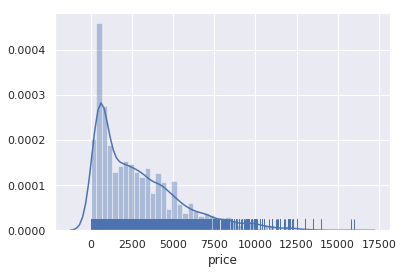

In [9]:
# replace missing price values with msrp and then plot
munged_df.price.fillna(munged_df.msrp, inplace=True)
sns.distplot(munged_df.price, rug=True)

## Test-Train Split Preprocessing
From quick glance of the dataset, it looks like it needs a little more data cleaning before we can proceed with test set hold out.

#### Tasks:
1. Remove samples that missing values for all fields except "brand", "price", "brake_type" which have no missing values.
2. We have prices less than zero, we should drop samples with bike prices less than a certain threshold
3. Look at **bike_type** field and determine if we need to drop any specific values. We care primarily about adult bikes excluding bmx.

In [10]:
# Identify samples with empty rows
empty_rows_df = munged_df[(munged_df.frame_material.isnull()) & (munged_df.model_year.isnull())
         & (munged_df.fork_material.isnull()) & (munged_df.handlebar_material.isnull())
         & (munged_df.fd_groupset.isnull()) & (munged_df.rd_groupset.isnull())
         & (munged_df.cassette_groupset.isnull()) & (munged_df.crankset_material.isnull())
         & (munged_df.crankset_groupset.isnull()) & (munged_df.seatpost_material.isnull())
         & (munged_df.chain_groupset.isnull()) & (munged_df.shifter_groupset.isnull())]
empty_rows_df.head()

,site,bike_type,product_id,href,description,brand,price,msrp,frame_material,model_year,...,fork_material,handlebar_material,fd_groupset,rd_groupset,cassette_groupset,crankset_material,crankset_groupset,seatpost_material,chain_groupset,shifter_groupset
354,jenson,kid,BI223K01,/Strider-12-Sport-Kids-Balance-Bike,Strider 12 Sport Kids Balance Bike,Strider,109.99,119.99,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,jenson,kid,BI001267,/Strider-14x-Sport-Kids-Balance-Bike,Strider 14x Sport Kids Balance Bike,Strider,189.99,209.99,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,nashbar,gravel,1147420,https://www.nashbar.com/bombtrack-hook-2-cyclo...,Bombtrack Hook 2 Cyclocross/Gravel Bike (Black...,Bombtrack,2309.99,1999.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,nashbar,gravel,1151838,https://www.nashbar.com/ridley-xride-disc-riva...,Ridley X-Ride Disc Rival 1 Cyclocross Bike (Grey),Ridley,1669.00,1399.99,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382,nashbar,hybrid,1147425,https://www.nashbar.com/bombtrack-outlaw-urban...,Bombtrack Outlaw Urban Bike (Black) (650B),Bombtrack,1498.99,1189.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# confirm they do indeed have empty values for other columns
empty_rows_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 354 to 9593
Data columns (total 21 columns):
site                  261 non-null object
bike_type             261 non-null object
product_id            261 non-null object
href                  261 non-null object
description           261 non-null object
brand                 261 non-null object
price                 261 non-null float64
msrp                  261 non-null float64
frame_material        0 non-null object
model_year            0 non-null float64
brake_type            0 non-null object
fork_material         0 non-null object
handlebar_material    0 non-null object
fd_groupset           0 non-null object
rd_groupset           0 non-null object
cassette_groupset     0 non-null object
crankset_material     0 non-null object
crankset_groupset     0 non-null object
seatpost_material     0 non-null object
chain_groupset        0 non-null object
shifter_groupset      0 non-null object
dtypes: float64(3), object(18)
me

In [12]:
# Identify products with prices less than or equal to 0
low_price_df = munged_df[(munged_df.price <= 0)]
low_price_df.head()

,site,bike_type,product_id,href,description,brand,price,msrp,frame_material,model_year,...,fork_material,handlebar_material,fd_groupset,rd_groupset,cassette_groupset,crankset_material,crankset_groupset,seatpost_material,chain_groupset,shifter_groupset
374,nashbar,hybrid,915795,https://www.nashbar.com/tuesday-june-7-24-wome...,"Tuesday June 7 24"" Women's Cruiser (Blue)",Tuesday,0.0,0.0,steel,NaN,...,steel,steel,NaN,shimano tourney,shimano tourney,steel,NaN,steel,NaN,shimano 7-speed
378,nashbar,hybrid,915798,https://www.nashbar.com/tuesday-june-1-womens-...,Tuesday June 1 Women's Cruiser (White),Tuesday,0.0,0.0,steel,NaN,...,steel,steel,NaN,NaN,single speed,steel,NaN,steel,NaN,NaN
379,nashbar,hybrid,945064,https://www.nashbar.com/tuesday-june-7-womens-...,Tuesday June 7 Women's Cruiser Bike (Vintage W...,Tuesday,0.0,0.0,steel,NaN,...,steel,steel,NaN,shimano tourney,shimano tourney,steel,NaN,steel,NaN,shimano 7-speed
384,nashbar,hybrid,915800,https://www.nashbar.com/tuesday-may-1-mens-cru...,Tuesday May 1 Men's Cruiser Bike (Black),Tuesday,0.0,0.0,steel,NaN,...,steel,steel,NaN,NaN,single speed,steel,NaN,steel,NaN,NaN
386,nashbar,hybrid,945069,https://www.nashbar.com/tuesday-august-7-women...,Tuesday August 7 Women's Cruiser Bike (Blush P...,Tuesday,0.0,0.0,aluminium,NaN,...,steel,alloy,NaN,shimano tourney,shimano tourney,alloy,NaN,alloy,NaN,shimano 7-speed


In [13]:
# Identify bike_type values that should be dropped
munged_df.bike_type.value_counts()

mountain       3853
road           2345
hybrid          482
electric        353
commuter        338
bmx             330
kid             272
gravel          253
childrens       195
pavement        186
cyclocross      176
fitness         164
cruiser         123
comfort         123
other           122
youth_bikes     105
urban            35
specialty        33
adventure        31
touring          23
singlespeed      13
triathlon        11
time_trial        9
ebikes            6
track             5
dirt_jump         5
ebike             3
fat               2
Name: bike_type, dtype: int64

In [14]:
# Drop bmx, kid, chidren's, and youth_bikes bikes and focus on adult bikes only
non_adult_df = munged_df[(munged_df.bike_type == 'bmx') | (munged_df.bike_type == 'kid')
                        | (munged_df.bike_type == 'childrens') | (munged_df.bike_type == 'youth_bikes')]
non_adult_df.head()

,site,bike_type,product_id,href,description,brand,price,msrp,frame_material,model_year,...,fork_material,handlebar_material,fd_groupset,rd_groupset,cassette_groupset,crankset_material,crankset_groupset,seatpost_material,chain_groupset,shifter_groupset
346,jenson,kid,BI001452,/Liv-Adore-CB-12-Bike-2020,Liv Adore C/B 12 Bike 2020,Liv,210.00,210.00,aluminium,2020.0,...,steel,NaN,NaN,NaN,NaN,steel,NaN,alloy,NaN,NaN
347,jenson,kid,BI001190,/Marin-Hawk-Hill-Jr-24-Bike-2020,"Marin Hawk Hill Jr 24"" Bike 2020",Marin,1499.99,1599.99,aluminium,2020.0,...,NaN,aluminium,NaN,shimano deore,sunrace,steel,sram x1,alloy,sram x1,microshift
348,jenson,kid,BI001449,/Giant-Animator-CB-12-Bike-2020,Giant Animator C/B 12 Bike 2020,Giant,210.00,210.00,aluminium,2020.0,...,steel,NaN,NaN,NaN,NaN,alloy,NaN,alloy,NaN,NaN
349,jenson,kid,BI001323,/Marin-Bayview-Trail-24-Disc-Bike-2020,"Marin Bayview Trail 24"" Disc Bike 2020",Marin,419.99,419.99,aluminium,2020.0,...,NaN,NaN,NaN,shimano altus,shimano tourney,alloy,NaN,alloy,NaN,shimano 7-speed
350,jenson,kid,BI001451,/Liv-Adore-CB-16-Bike-2020,Liv Adore C/B 16 Bike 2020,Liv,230.00,230.00,aluminium,2020.0,...,steel,NaN,NaN,NaN,NaN,steel,NaN,alloy,NaN,NaN


In [15]:
# Create dataframe without dropped rows
drop_list = empty_rows_df.index.tolist() + low_price_df.index.tolist() + non_adult_df.index.tolist()
drop_list = set(drop_list)  # remove dupes
drop_count = len(drop_list)
print(f'There are {drop_count} samples to be dropped.')
print(f'There should be {len(munged_df) - drop_count} samles left afterwards.')
data_df = munged_df.drop(drop_list)
print(f'There are now {len(data_df)} samples remaining.')

There are 1207 samples to be dropped.
There should be 8389 samles left afterwards.
There are now 8389 samples remaining.


In [16]:
data_df.bike_type.value_counts()

mountain       3700
road           2286
hybrid          451
electric        353
commuter        320
gravel          251
pavement        184
cyclocross      170
fitness         163
comfort         116
other           115
cruiser         111
urban            35
specialty        33
adventure        31
touring          23
triathlon        11
time_trial        9
ebikes            6
singlespeed       6
track             5
dirt_jump         5
ebike             3
fat               2
Name: bike_type, dtype: int64

In [17]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8389 entries, 0 to 9576
Data columns (total 21 columns):
site                  8389 non-null object
bike_type             8389 non-null object
product_id            8389 non-null object
href                  8389 non-null object
description           8389 non-null object
brand                 8389 non-null object
price                 8389 non-null float64
msrp                  8389 non-null float64
frame_material        7774 non-null object
model_year            3461 non-null float64
brake_type            7572 non-null object
fork_material         4007 non-null object
handlebar_material    4106 non-null object
fd_groupset           3267 non-null object
rd_groupset           7111 non-null object
cassette_groupset     6780 non-null object
crankset_material     1950 non-null object
crankset_groupset     4844 non-null object
seatpost_material     3783 non-null object
chain_groupset        4511 non-null object
shifter_groupset      6564 non

### Price Distribution
With additional preprocessing completed, let's take another look at the numerical features, specifically price. After dropping non-adult bikes, rows with many empty values, and bike with prices less than or equal to 0 we're left with 8389 observations; 1207 rows removed.

Price distribution is unimodal and right skewed. We're dealing with an imbalanced data set with outliers beginning at \\$9000. This requires ensuring that the test, train split resemble the original distribution as much as possible to avoid introducing additional bias into the model.

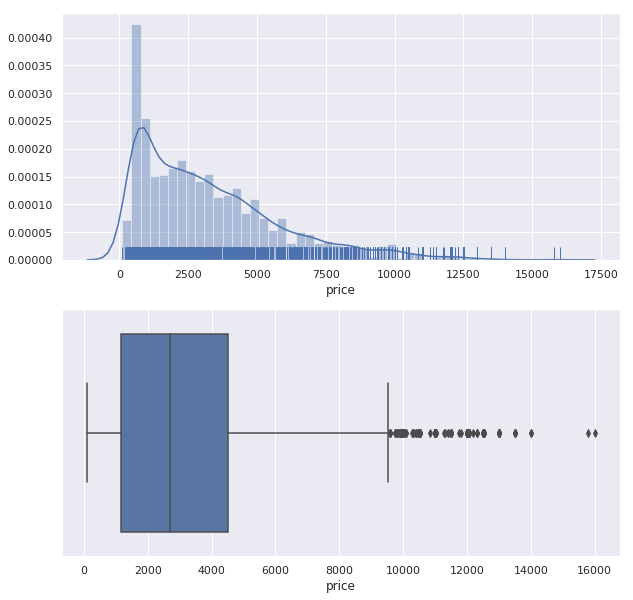

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.distplot(data_df.price, rug=True, ax=ax[0])
sns.boxplot(data_df.price, ax=ax[1])

## Train Test Split
Implement "stratified" split for preprocessed data. By doing so, the hope is to get a more reliable (lower bias and variance) estimate of model performance. Using regular random split on the dataset is likely to naturally introduce bias into the data or unintentionally exclude data points, and thus affect model performance. Using stratification during model selection produces better results because the validation set(s) more accurately represent the task we need to solve. If one class is hard to predict, we won’t have more of them (artificially hindering the performance metric) or less (assisting performance) if we use stratification.

#### Sorted Stratification
Since this a regression task and not classification, we need a method to define the "classification" sets of the data so we can ensure similar distribution of the target variable in both the train and test sets. The following approach will be used to achieve this:
1. Sort the samples on the target variable
2. Categorize samples into *k* partitions (or "classes") depending on test size needed
3. Utilize sklearn's "StratifiedShuffleSplit" to generate train vs test split

Alternative approach is to categorize samples by **bike_type** to ensure similar distribution of bike types between train and test sets. Categorizing by target variable is most likely the best since that is what we're predicting for. The latter might introduce other biases that we're unaware.

In [19]:
# Set random state for reproducibility purposes
RAND_STATE = 42

In [20]:
# We can simplify steps 1 and 2 by help of pandas.qcut method
num_bins = 4  # grouping into quantiles
price_cats = pd.qcut(x=data_df.price, q=num_bins, labels=range(num_bins))
price_cats.value_counts()

0    2110
2    2104
1    2100
3    2075
Name: price, dtype: int64

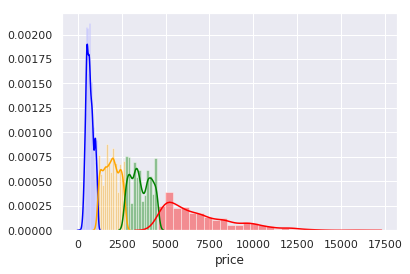

In [54]:
# Visually verify bins
sns.distplot(data_df.loc[price_cats == 0,].price, color='blue')
sns.distplot(data_df.loc[price_cats == 1,].price, color='orange')
sns.distplot(data_df.loc[price_cats == 2,].price, color='green')
sns.distplot(data_df.loc[price_cats == 3,].price, color='red')

In [37]:
# Generate shuffled train and test indices
train_idx, test_idx = next(
    StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=RAND_STATE).split(
        X=price_cats, y=price_cats
    )
)
print(f'Num train samples: {len(train_idx)}\nNum test samples: {len(test_idx)}')

Num train samples: 6711
Num test samples: 1678


train shape: (6711, 21)
test shape: (1678, 21)


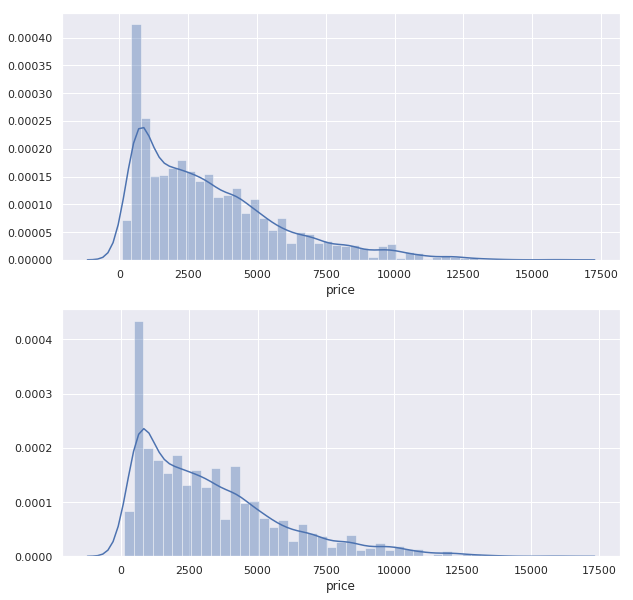

In [41]:
# Get train and test datasets
train_df = data_df.iloc[train_idx].copy()
test_df = data_df.iloc[test_idx].copy()  # Hold-out set - NO PEEKING!

# Verify dimensions and general distribution of original set vs training set
print(f'train shape: {train_df.shape}\ntest shape: {test_df.shape}')
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.distplot(data_df.price, ax=ax[0])
sns.distplot(train_df.price, ax=ax[1])

## Train Data Exploration and Feature Engineering
The data has many categorical fields. The first step is see how we can transform them into useful numerical fields. This will involving some one-hot encoding and identifying rankable values.

**price** and **model_year** are already numerical. Price is the target variable, so we won't directly touch this since we don't want to include it as a feature else we will be indirectly including what we want to predict as feature.

Let's look at each of the remaining categorical fields to see how best to utilize or whether to just drop them. Model year has some missing valaues so we will need to decide how we want to handle those missing values.

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6711 entries, 1321 to 3992
Data columns (total 21 columns):
site                  6711 non-null object
bike_type             6711 non-null object
product_id            6711 non-null object
href                  6711 non-null object
description           6711 non-null object
brand                 6711 non-null object
price                 6711 non-null float64
msrp                  6711 non-null float64
frame_material        6220 non-null object
model_year            2768 non-null float64
brake_type            6066 non-null object
fork_material         3220 non-null object
handlebar_material    3332 non-null object
fd_groupset           2613 non-null object
rd_groupset           5706 non-null object
cassette_groupset     5436 non-null object
crankset_material     1570 non-null object
crankset_groupset     3882 non-null object
seatpost_material     3069 non-null object
chain_groupset        3595 non-null object
shifter_groupset      5277 

### Bike Types
Let's take a quick look at the types of bikes in the dataset. We need to collapse some of these into similar types. For instance, electric, ebike, and ebikes should be the same types; the same can be said for mountain and fat.

Dirt jump bikes are a cross between mountain bikes and bmx bikes. Since we dropped bmx bikes we should drop these, especially since we only have data coming from a single source.

Actually after further analysis, need to rethink bike "types". For example, electric should not be it's on category, it's actually a subcategory. You can have electric mountain bike, electric cruiser, etc.

**Action:** re-review source sites and determine high-level bike types, the appropriate subcategories for each, and similar categories that can be collapsed into same high-level or sub-level category. Back to updating scraper!

In [160]:
train_df.bike_type.value_counts()

mountain       2970
road           1838
hybrid          365
electric        275
commuter        258
gravel          202
pavement        147
fitness         129
cyclocross      127
comfort          93
other            89
cruiser          85
specialty        31
urban            26
adventure        21
touring          17
triathlon        11
time_trial        6
track             5
dirt_jump         5
singlespeed       4
ebike             3
fat               2
ebikes            2
Name: bike_type, dtype: int64

In [ ]:
munged_train_df = train_df.copy()
bike_type_remap = {
    'ebike': 'electric',
    'ebikes': 'electric',
    'time_trial': 'triathlon',
    'fat': 'mountain',
    'singlespeed': 'road'  # don't have enough samples to treat as own category
    
}

### Sites Scraped
Our data is sourced from 19 different websites. It is unlikely that each website provides an equal number of observations so let's take a look at the relationship between the data sources, bike types, and their relation to price.

Questions to answer:
* Are there sites that predominantly sell only expensive bikes or vice versa?
* Do we get a good distribution of bike types across sources?
* Does certain sites have less or more incomplete data?

In [60]:
# itemize sources and check all
data_sources = orig_df.site.unique()
print('Data sources used for collecting data:', data_sources)
f'Are all sources in train data: {True if len(train_df.site.unique()) == len(data_sources) else False}'

Data sources used for collecting data: ['jenson' 'nashbar' 'trek' 'rei' 'citybikes' 'proshop' 'contebikes'
 'eriks' 'canyon' 'giant' 'litespeed' 'lynskey' 'spokes' 'specialized'
 'backcountry' 'bike_doctor' 'bicycle_warehouse' 'wiggle' 'competitive']


'Are all sources in train data: True'

The majority of our data comes from 8 of the 19 sources, which account for about 5000 of 6711 observations we have in the training set. Canyon, nashbar, lynskey, and litespeed sources each have less than 100 observations.

Lynskey and litespeed sources only make titanium bikes, so it isn't surprising that they account for ~20 observations each. Titanium frame is still a relatively new material used for bikes; it's a popular alternative for the in demand carbon frames with similar rigidity and strength. Finding sites that produced titanium bikes and provided sufficient component materials was difficult. Many producers of titanium bikes don't have many models ready for sale and rely on base specs with build-on-demand requests which then dictate the price per components selected. This made it difficult to collect more observations for this frame material.

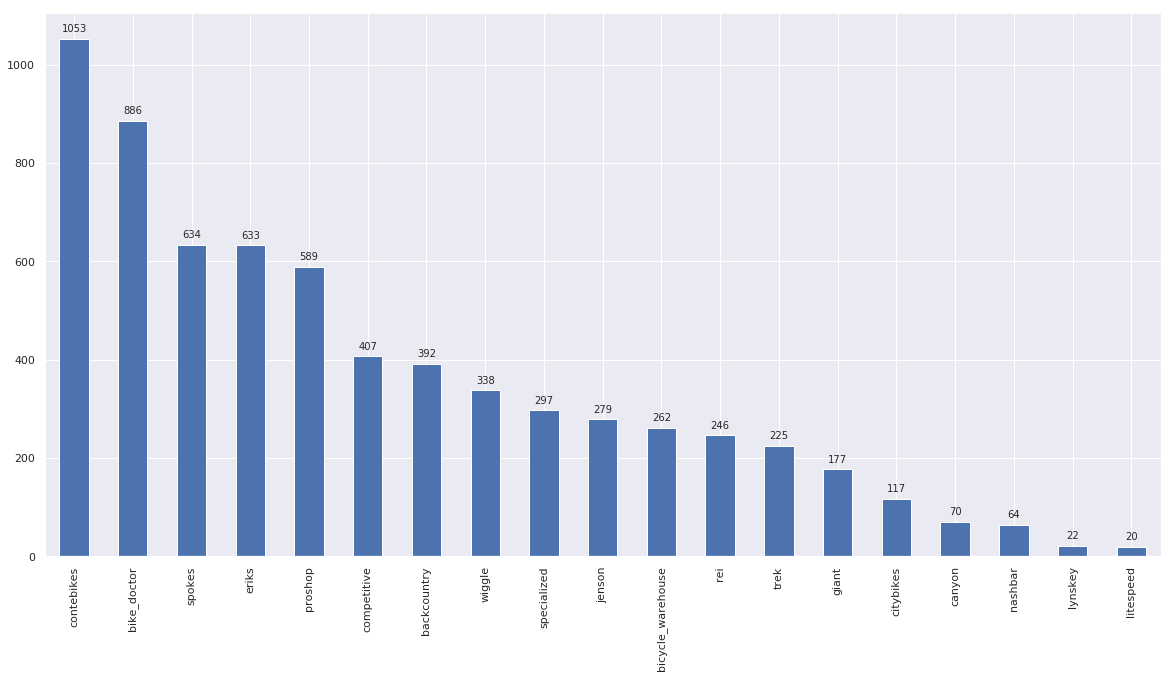

In [105]:
site_counts = train_df.site.value_counts()
ax = site_counts.plot(kind='bar', figsize=(20, 10))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center', xytext=(0, 10), textcoords='offset points')

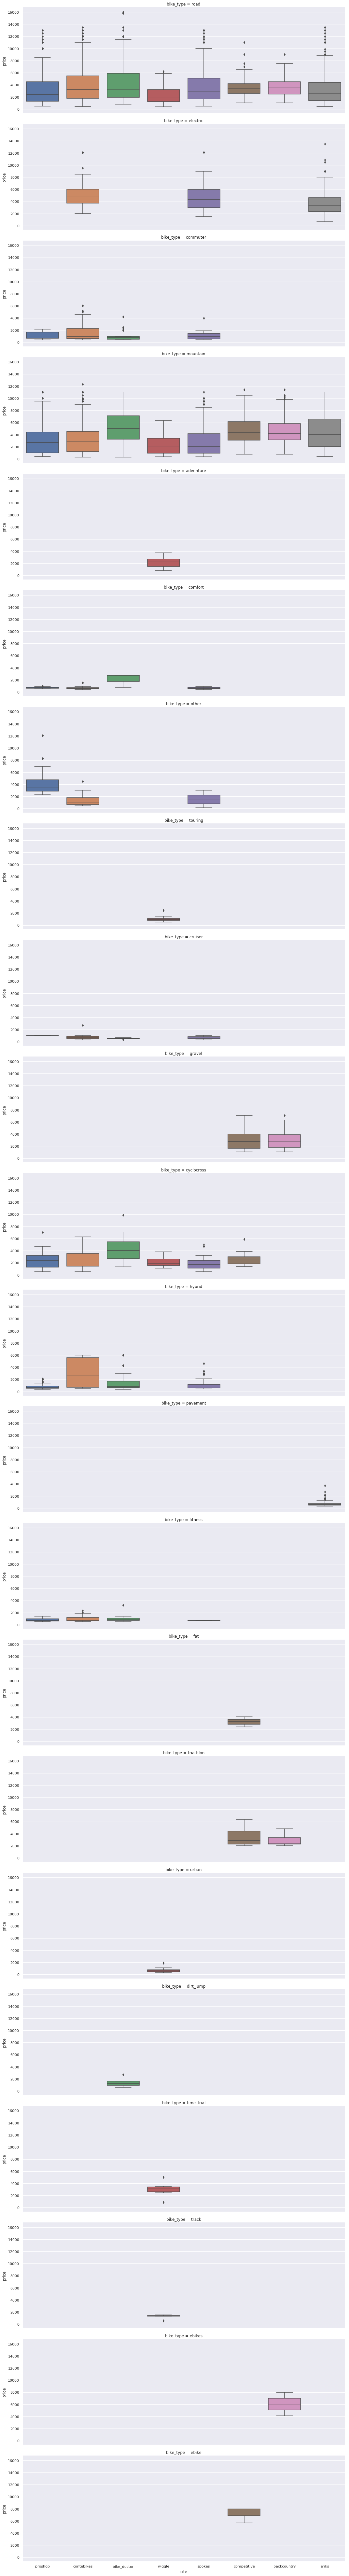

In [159]:
top_sites = site_counts.index[:8]
top_df = train_df.loc[train_df.site.isin(top_sites), ['site', 'bike_type', 'price']]
sns.catplot(data=top_df, x='site', y='price', row='bike_type', kind='box', height=5, aspect=3)

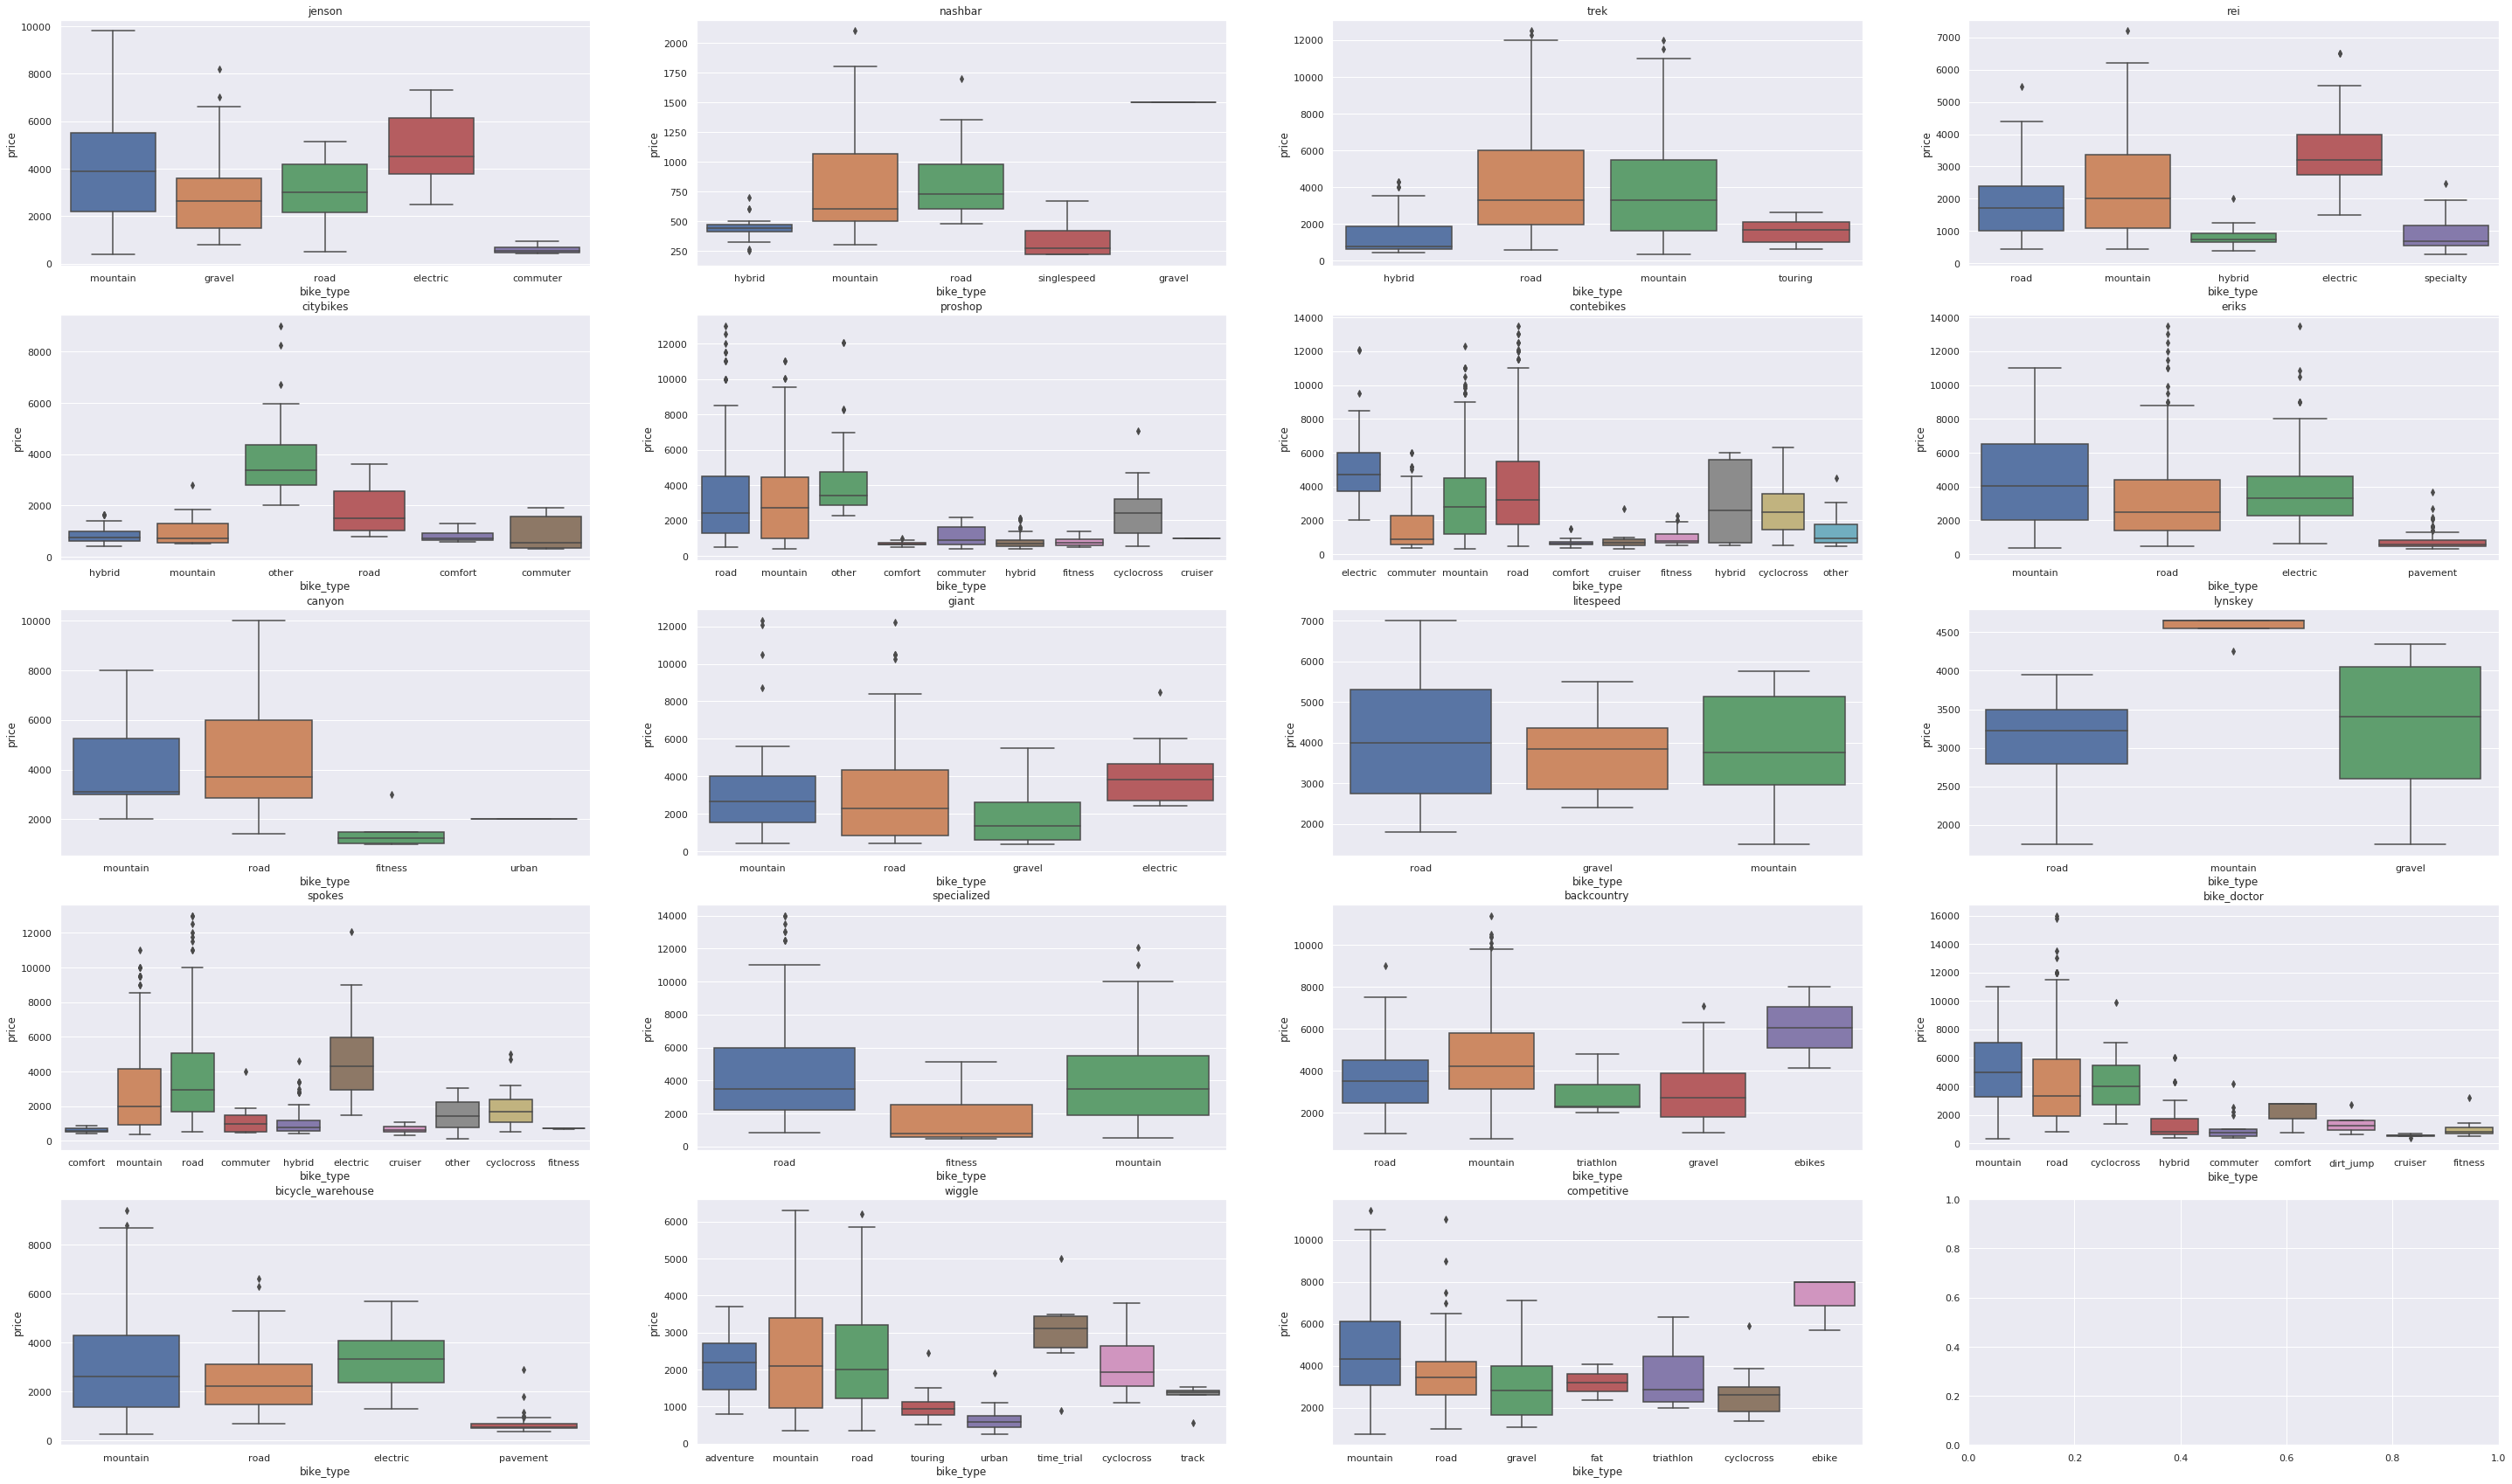

In [131]:
fig, ax = plt.subplots(5, 4, figsize=(50, 30))
row = 0
for i, site in enumerate(data_sources):
    col = i % 4
    if i >= 4 and col == 0:
        row += 1
    tmp_df = train_df.loc[train_df.site == site, ['bike_type', 'price']]
    sns.boxplot(x=tmp_df.bike_type, y=tmp_df.price, ax=ax[row][col])
    ax[row][col].set_title(site)
plt.show()

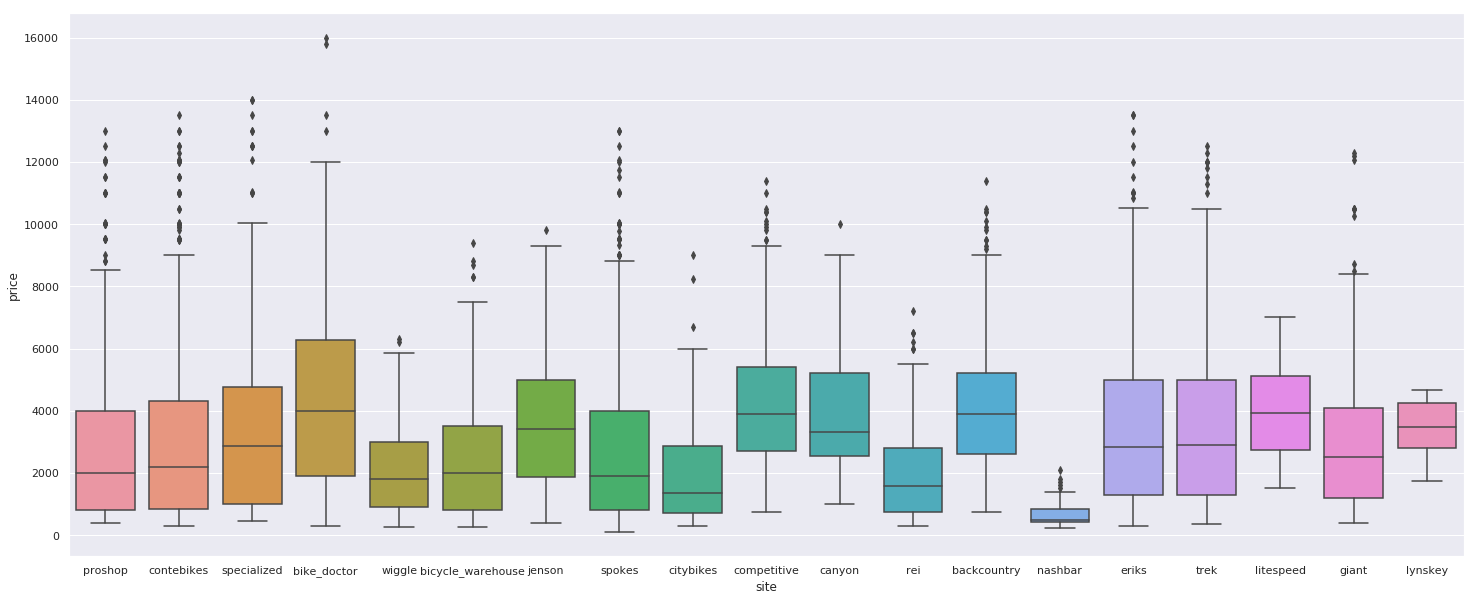

In [68]:
plt.figure(figsize=(25, 10))
sns.boxplot(x=train_df.site, y=train_df.price)

### Frame Material
There are 6220 non-null samples. Looking at value counts, we see majority of frame material are either carbon or aluminium/alloy material. This is typical of what you would expect, majority of bikes these day are primarily aluminium or some alloy-hybrid and for top-end there's a high demand for carbon due to its lightness and stiffness. The average price per frame material confirms this.

Carbon frame bikes are considerably more expensive than aluminium or alloy frame bikes, about twice the price. Titanium also seems to garner higher price but we only have a few samples represented in train dataset so we should consider trying to get more data for such bikes.

Chromoly steel is a type of low alloy steel that gets its name from a combination of the words “chromium” and “molybdenum” – two of the major alloying elements. Chromoly steel is often used when more strength is required than that of mild carbon steel, though it often comes at an increase in cost. Though surprisingly, there isn't much difference in pricing from regular steel so might be worth collapsing them into single steel-chromo category.

Alloy material for bikes implies aluminium alloy, despite the destinction here, all aluminium frames are alloy. So these two categories should be collapsed into single aluminium. **Additionally, we should do additional data integrity to ensure that chromoly(/steel) frames are not being misclassified as "alloy" when we move onto preparing the data of modeling.**

##### Feature Engineering Outcome
So for frame material, we will have four final categories: aluminium, carbon, steel, and titanium. Aluminium is the standard fram you'll find for most bikes so we will treat this as the base value for the feature and one-hot encode the other three.

carbon       2760
aluminium    2074
alloy         948
chromoly      272
steel         116
titanium       50
Name: frame_material, dtype: int64


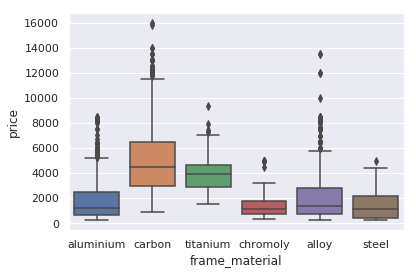

In [64]:
print(train_df.frame_material.value_counts())
grouped = train_df.groupby('frame_material')
sns.boxplot(x=train_df.frame_material, y=train_df.price)

In [46]:
train_df['steel_frame'] = train_df.frame_material.apply(lambda x: 1 if x == 'steel' or x == 'chromoly' else 0)
train_df.steel_frame.value_counts()

0    6323
1     388
Name: steel_frame, dtype: int64

In [47]:
train_df['carbon_frame'] = train_df.frame_material.apply(lambda x: 1 if x == 'carbon' else 0)
train_df.carbon_frame.value_counts()

0    3951
1    2760
Name: carbon_frame, dtype: int64

In [48]:
train_df['titanium_frame'] = train_df.frame_material.map(lambda x: 1 if x == 'titanium' else 0)
train_df.titanium_frame.value_counts()

0    6661
1      50
Name: titanium_frame, dtype: int64

#### Other Material Categorical Fields
Except for fork material, we see that carbon material continues to have a strong relationship to price for other material based fields. So we will implement similar one-hot encoding to extract numerical features for these fields.

In [49]:
print(train_df.handlebar_material.value_counts())
grouped = train_df.groupby('handlebar_material')
grouped['price'].mean()

alloy        2180
carbon        828
aluminium     285
steel          38
chromoly        1
Name: handlebar_material, dtype: int64


handlebar_material
alloy        2257.014807
aluminium    2715.252632
carbon       7615.193043
chromoly     5400.000000
steel         603.255263
Name: price, dtype: float64

In [ ]:
sns.boxplot(x=train_df.handlebar_material, y=train_df.price)

In [ ]:
train_df['carbon_handlebar'] = train_df.handlebar_material.apply(lambda x: 1 if x == 'carbon' else 0)
train_df.carbon_handlebar.value_counts()

In [ ]:
print(train_df.crankset_material.value_counts())
grouped = train_df.groupby('crankset_material')
grouped['price'].mean()

In [ ]:
sns.boxplot(x=train_df.crankset_material, y=train_df.price)

In [ ]:
train_df['carbon_crankset'] = train_df.crankset_material.apply(lambda x: 1 if x == 'carbon' else 0)
train_df.carbon_crankset.value_counts()

In [ ]:
print(train_df.seatpost_material.value_counts())
grouped = train_df.groupby('seatpost_material')
grouped['price'].mean()

In [ ]:
sns.boxplot(x=train_df.seatpost_material, y=train_df.price)

In [ ]:
train_df['carbon_seatpost'] = train_df.seatpost_material.apply(lambda x: 1 if x == 'carbon' else 0)
train_df.carbon_seatpost.value_counts()

Alloy, aluminium, and carbon fork have relatively same average price. Surprisingly, having steel and chromoly fork has strong negative relationship to price. For this, we will implement one-hot encoding for steel and chromoly fork material; or rather one-hot encoding for non-carbon, alloy, aluminium for material.

In [ ]:
print(train_df.fork_material.value_counts())
grouped = train_df.groupby('fork_material')
grouped['price'].mean()

In [ ]:
sns.boxplot(x=train_df.fork_material, y=train_df.price)

In [ ]:
train_df['carbon_fork'] = train_df.fork_material.apply(lambda x: 1 if x == 'carbon' else 0)
train_df.carbon_fork.value_counts()

#### Brake Type

In [ ]:
print(train_df.brake_type.value_counts())
grouped = train_df.groupby('brake_type')
grouped['price'].mean()

In [ ]:
train_df[(train_df.brake_type == 'disc') | (train_df.brake_type == 'hydraulic') | (train_df.brake_type == 'mechanical')].mean()

In [ ]:
train_df['disc_brakes'] = train_df.brake_type.apply(lambda x: 1 if x == 'disc' or x == 'hydraulic' or x == 'mechanical' else 0)
train_df.disc_brakes.value_counts()

In [ ]:
train_df['hydraulic_disc_brakes'] = train_df.brake_type.apply(lambda x: 1 if x == 'hydraulic' else 0)
train_df.hydraulic_disc_brakes.value_counts()

In [ ]:
train_df['mechanical_disc_brakes'] = train_df.brake_type.apply(lambda x: 1 if x == 'mechanical' else 0)
train_df.mechanical_disc_brakes.value_counts()

In [ ]:
train_df[train_df.brake_type == 'other'] ### DATA INTEGRITY ISSUES - NEED TO CLEAN UP DATA PIPELINE
# Seem to have framesets in samples and unnecessarily incomplete samples which have actual specs on website